In [10]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pandas as pd
import numpy as np

# 仮想データフレームを作成します（実際にはここでデータを読み込む）
# 以下はデータ構造を模倣したもので、実際のデータではないことに注意してください。
data = {
    "yad_no": [1, 2, 3, 4, 5],
    "yad_type": [0, 0, 0, 0, 0],
    "total_room_cnt": [129.0, 23.0, 167.0, 144.0, 41.0],
    "wireless_flg": [1.0, 1.0, 1.0, 1.0, np.nan],
    "onsen_flg": [0, 0, 1, 0, 1],
    # その他のカラム...
    "wid_cd": ["f0112abf369fb...", "d86102dd9c232b...", "4e63881f921c3...", "107c735a74c8d...", "75617b0a72785..."],
    # 他のカテゴリカル変数のカラムもここに含まれると仮定します。
}
df = pd.DataFrame(data)

# 欠損値を処理します。ここでは単純に欠損値を持つカラムを削除しますが、
# 実際には欠損値を適切な方法で補完することを検討してください。
df.fillna("unknown", inplace=True)

# TaggedDocumentのリストを作成します。
documents = [
    TaggedDocument(words=[str(row[yad_type]) for yad_type in df.columns if yad_type != "yad_no"], tags=[row["yad_no"]])
    for index, row in df.iterrows()
]

# Doc2Vecモデルを構築し、トレーニングします。
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4)
model.build_vocab(documents)
for epoch in range(model.epochs):
    loss = model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
    print("Epoch #{}: loss={}".format(epoch, loss))


# トレーニングしたモデルを保存することもできます。

Epoch #0: loss=None
Epoch #1: loss=None
Epoch #2: loss=None
Epoch #3: loss=None
Epoch #4: loss=None
Epoch #5: loss=None
Epoch #6: loss=None
Epoch #7: loss=None
Epoch #8: loss=None
Epoch #9: loss=None


/var/folders/z0/sjx59b5j2ql1n4gd96t8rlg40000gq/T/ipykernel_27321/296634399.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("unknown", inplace=True)


In [53]:
from scorta.recsys.candidate_generate import Candidate, CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
from atma_16.utils.polars_utils import min_max_scaler, over_rank
import polars as pl
from typing import Literal
import polars.selectors as cs

# cand = Candidate("")
# cand.generate()

input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()


yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

{1: {'eval_time': '2023/12/10/05:20:25',
  'cg_name': 'LastSeenedCandidate_train',
  'pair_cnt': 103312,
  'unique_user_cnt': 103312,
  'unique_item_cnt': 9502,
  'eval_dic': {1: {'precision@1': 0.7223943007588663,
    'recall@1': 0.2585123554718079,
    'f1@1': 0.38076579679089817}}},
 5: {'eval_time': '2023/12/10/05:20:25',
  'cg_name': 'LastSeenedCandidate_train',
  'pair_cnt': 130455,
  'unique_user_cnt': 103312,
  'unique_item_cnt': 9516,
  'eval_dic': {1: {'precision@5': 0.7087731401632746,
    'recall@5': 0.31507012689628855,
    'f1@5': 0.43622544660233115}}},
 10: {'eval_time': '2023/12/10/05:20:25',
  'cg_name': 'LastSeenedCandidate_train',
  'pair_cnt': 130572,
  'unique_user_cnt': 103312,
  'unique_item_cnt': 9516,
  'eval_dic': {1: {'precision@10': 0.7088502894954508,
    'recall@10': 0.3152871123889072,
    'f1@10': 0.43644800098082437}}},
 50: {'eval_time': '2023/12/10/05:20:25',
  'cg_name': 'LastSeenedCandidate_train',
  'pair_cnt': 130572,
  'unique_user_cnt': 103312,

In [70]:
from atma_16.candidate.candidate import LastSeenedCandidate, PopularAtCDCandidate

train_candidates = [LastSeenedCandidate(dl, target_df=target_df), PopularAtCDCandidate(dl, target_df=target_df)]
test_candidates = [
    LastSeenedCandidate(dl, mode="test"),
    PopularAtCDCandidate(dl, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}
for mode, candidates in cands_dic.items():
    for cand in candidates:
        df = cand.generate()
        cand.save(df)
        print(cand.evaluator.evaluate(df, cand.class_name))

    cm = CandidateMerger(
        dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
    )
    merged_df = cm.merge()
    cm.save(merged_df)

{1: {'eval_time': '2023/12/10/05:29:35', 'cg_name': 'LastSeenedCandidate_train', 'pair_cnt': 103312, 'unique_user_cnt': 103312, 'unique_item_cnt': 9502, 'eval_dic': {1: {'precision@1': 0.7223943007588663, 'recall@1': 0.2585123554718079, 'f1@1': 0.38076579679089817}}}, 5: {'eval_time': '2023/12/10/05:29:35', 'cg_name': 'LastSeenedCandidate_train', 'pair_cnt': 130455, 'unique_user_cnt': 103312, 'unique_item_cnt': 9516, 'eval_dic': {1: {'precision@5': 0.7087731401632746, 'recall@5': 0.31507012689628855, 'f1@5': 0.43622544660233115}}}, 10: {'eval_time': '2023/12/10/05:29:35', 'cg_name': 'LastSeenedCandidate_train', 'pair_cnt': 130572, 'unique_user_cnt': 103312, 'unique_item_cnt': 9516, 'eval_dic': {1: {'precision@10': 0.7088502894954508, 'recall@10': 0.3152871123889072, 'f1@10': 0.43644800098082437}}}, 50: {'eval_time': '2023/12/10/05:29:35', 'cg_name': 'LastSeenedCandidate_train', 'pair_cnt': 130572, 'unique_user_cnt': 103312, 'unique_item_cnt': 9516, 'eval_dic': {1: {'precision@50': 0.70

2it [00:00, 13.35it/s]


{1: {'eval_time': '2023/12/10/05:29:41', 'cg_name': 'LastSeenedCandidate_test', 'pair_cnt': 60760, 'unique_user_cnt': 60760, 'unique_item_cnt': 8000, 'eval_dic': {}}, 5: {'eval_time': '2023/12/10/05:29:41', 'cg_name': 'LastSeenedCandidate_test', 'pair_cnt': 75569, 'unique_user_cnt': 60760, 'unique_item_cnt': 8015, 'eval_dic': {}}, 10: {'eval_time': '2023/12/10/05:29:41', 'cg_name': 'LastSeenedCandidate_test', 'pair_cnt': 75605, 'unique_user_cnt': 60760, 'unique_item_cnt': 8015, 'eval_dic': {}}, 50: {'eval_time': '2023/12/10/05:29:41', 'cg_name': 'LastSeenedCandidate_test', 'pair_cnt': 75605, 'unique_user_cnt': 60760, 'unique_item_cnt': 8015, 'eval_dic': {}}, 100: {'eval_time': '2023/12/10/05:29:41', 'cg_name': 'LastSeenedCandidate_test', 'pair_cnt': 75605, 'unique_user_cnt': 60760, 'unique_item_cnt': 8015, 'eval_dic': {}}}
{1: {'eval_time': '2023/12/10/05:29:42', 'cg_name': 'PopularAtCDCandidate_test', 'pair_cnt': 174700, 'unique_user_cnt': 174700, 'unique_item_cnt': 568, 'eval_dic': {

2it [00:00, 23.46it/s]


In [77]:
train_df = CandidateMerger(dl, candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

In [78]:
yado_feat = dl.load_yado().select(~cs.string())

train_df = train_df.join(yado_feat, how="left", on="yad_no")
test_df = test_df.join(yado_feat, how="left", on="yad_no")

In [79]:
X_train = train_df.drop("label")
y_train = train_df["label"]

In [80]:
cat_params = {
    "iterations": 1000,
    "learning_rate": 0.03,
    "depth": 6,
    "loss_function": "Logloss",
    "random_seed": 42,
    "early_stopping_rounds": 50,
}

from scorta.model.gradient_boost import GBTWrapper

gbdt = GBTWrapper("cat", "bin")
models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=cat_params)

0:	learn: 0.6437271	test: 0.6437927	best: 0.6437927 (0)	total: 151ms	remaining: 2m 31s
1:	learn: 0.5985988	test: 0.5986698	best: 0.5986698 (1)	total: 231ms	remaining: 1m 55s
2:	learn: 0.5574210	test: 0.5574789	best: 0.5574789 (2)	total: 315ms	remaining: 1m 44s
3:	learn: 0.5204429	test: 0.5204733	best: 0.5204733 (3)	total: 406ms	remaining: 1m 41s
4:	learn: 0.4864473	test: 0.4864485	best: 0.4864485 (4)	total: 543ms	remaining: 1m 48s
5:	learn: 0.4556150	test: 0.4555922	best: 0.4555922 (5)	total: 617ms	remaining: 1m 42s
6:	learn: 0.4276051	test: 0.4275675	best: 0.4275675 (6)	total: 695ms	remaining: 1m 38s
7:	learn: 0.4023237	test: 0.4022687	best: 0.4022687 (7)	total: 773ms	remaining: 1m 35s
8:	learn: 0.3790455	test: 0.3789802	best: 0.3789802 (8)	total: 855ms	remaining: 1m 34s
9:	learn: 0.3582135	test: 0.3581438	best: 0.3581438 (9)	total: 929ms	remaining: 1m 32s
10:	learn: 0.3390774	test: 0.3390102	best: 0.3390102 (10)	total: 1s	remaining: 1m 30s
11:	learn: 0.3216873	test: 0.3216225	best: 0

In [82]:
train_df

session_id,yad_no,LastSeenedCandidate_train_score,LastSeenedCandidate_train_rank,PopularAtCDCandidate_train_score,PopularAtCDCandidate_train_rank,cand_selected_cnt,sum_score,rank,label,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min
i64,i64,f64,u32,f64,u32,u32,f64,f64,i32,i64,f64,f64,i64,f64,f64,f64,f64
0,11101,null,null,0.009377,1,1,0.009377,1.0,0,0,381.0,1.0,0,1.0,null,null,1.0
0,11134,null,null,0.007345,2,1,0.007345,2.0,0,0,347.0,1.0,0,1.0,null,null,1.0
0,7157,null,null,0.005861,3,1,0.005861,3.0,0,0,494.0,1.0,0,1.0,null,null,1.0
0,4391,null,null,0.003595,4,1,0.003595,4.0,0,0,48.0,1.0,1,null,null,null,null
0,5821,null,null,0.003204,5,1,0.003204,5.0,0,0,171.0,1.0,0,1.0,null,null,1.0
0,1648,null,null,0.003048,6,1,0.003048,6.0,0,0,180.0,1.0,0,1.0,null,null,1.0
0,12837,null,null,0.002891,7,1,0.002891,7.0,0,0,150.0,1.0,0,1.0,null,null,1.0
0,997,null,null,0.002813,8,1,0.002813,8.0,0,0,250.0,1.0,0,1.0,null,null,null
0,12846,null,null,0.002422,9,1,0.002422,9.0,0,0,193.0,1.0,0,1.0,null,null,1.0


In [105]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

0.370194522490416


/Users/zerebom/ghq/github.com/zerebom/scorta/scorta/eda/df.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, y="column", x="feature_importance", order=order, ax=ax, palette="viridis")


(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

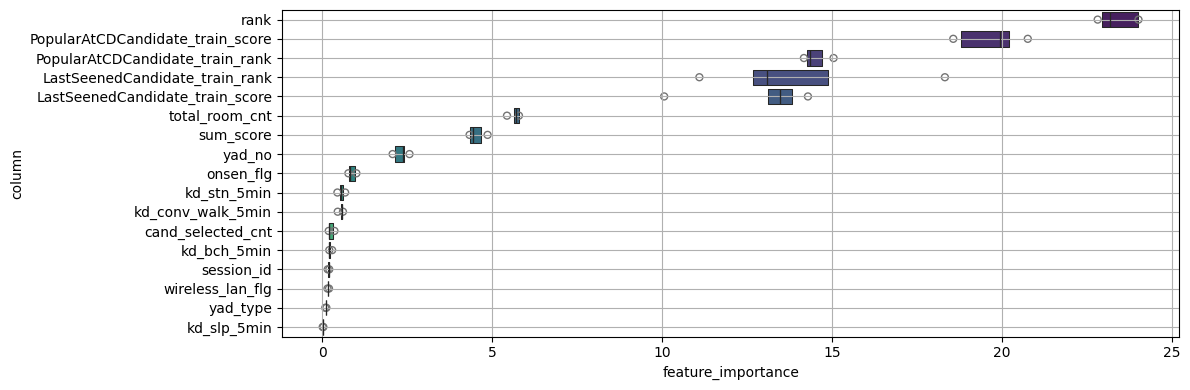

In [85]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(gbdt.feature_importance(), X_train.to_pandas())

In [88]:
import numpy as np

preds = np.array([gbdt.predict(test_df.to_pandas(), i) for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

array([-3.91136179, -4.26695521, -4.49063435, ...,  2.034518  ,
        1.97723647,  1.79688311])

<Axes: ylabel='Count'>

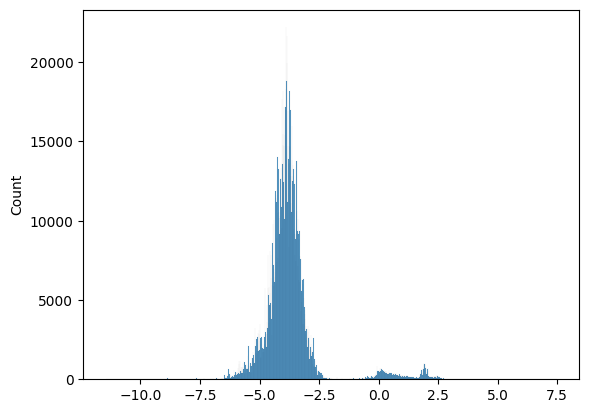

In [92]:
import seaborn as sns

sns.histplot(preds)

<Axes: ylabel='Count'>

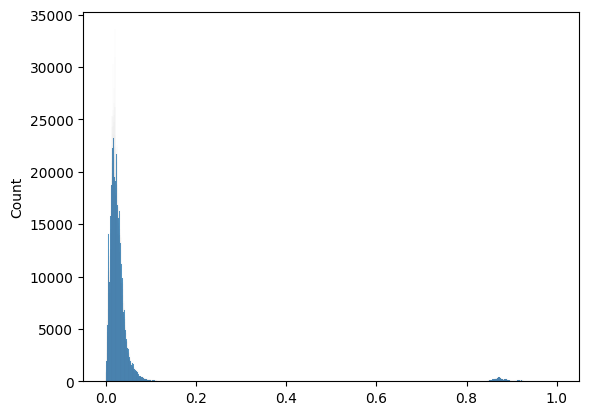

In [94]:
sns.histplot(oof[:, 1])

In [95]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [104]:

    (sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no"))

session_id,yad_no
i64,list[i64]
288698,"[3560, 9534, … 5466]"
288699,"[6129, 11923, … 613]"
288700,"[757, 1774, … 9190]"
288701,"[12341, 13610, … 13521]"
288702,"[2862, 11480, … 13590]"
288703,"[5066, 385, … 12785]"
288704,"[850, 28, … 3947]"
288705,"[10904, 13347, … 5015]"
288706,"[4522, 10541, … 3244]"


In [100]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [101]:
np.array(fill_sub_lists).shape

(174700, 10)

In [107]:
exp_name = "002_create_candidate_class"
output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}.csv", index=False)